In [1]:
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt

In [2]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    if rescale:
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    return img
    

def get_pixels_hu(image_path, rescale=True): ## Just using hu values
        dicom = pydicom.read_file(image_path)
        image = dicom.pixel_array.astype(np.int16)

    # The intercept is usually -1024, so air is approximately 0
         
    # Convert to Hounsfield units (HU)
        intercept = dicom.RescaleIntercept
        slope = dicom.RescaleSlope
    
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
        
        image += np.int16(intercept)
    
        image[image < -1024] = -1024 # Setting values smaller than air, to air .
        if rescale:
        # Extra rescaling to 0-1
            image = (image - 0) / (max(max(image))- 0)
        return np.array(image, dtype=np.int16)
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)      
    
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

def img_crop(img):
    thresholded = cv2.threshold(img.astype('uint8'),0,255,cv2.THRESH_OTSU)
    bbox = cv2.boundingRect(thresholded[1])
    x, y, w, h = bbox
    foreground = img[y:y+h, x:x+w]
    return foreground


def preprocess(dcm):    
    window_center , window_width, intercept, slope = get_windowing(dcm)
    img = dcm.pixel_array
    img = window_image(img, window_center, window_width, intercept, slope)
    img = img_crop(img)
    resized = cv2.resize(img, (224, 224))
    return resized

In [3]:
def mult(image, kernel, startx, starty):
    combo = 0
    (r, c) = kernel.shape[0], kernel.shape[1]
    for i in range(startx, startx+r):
        for j in range(starty, starty+c):
            combo += (image[i][j]*kernel[i-startx][j-starty])
    return combo
def filter_lin(image, kernel):
    (x, y) = image.shape
    (r, c) = kernel.shape
    out = []
    for i in range(x-r):
        row = []
        for j in range(y-c):
            row.append(mult(image, kernel, i, j))
        out.append(row)
    out = np.array(out)
    return out


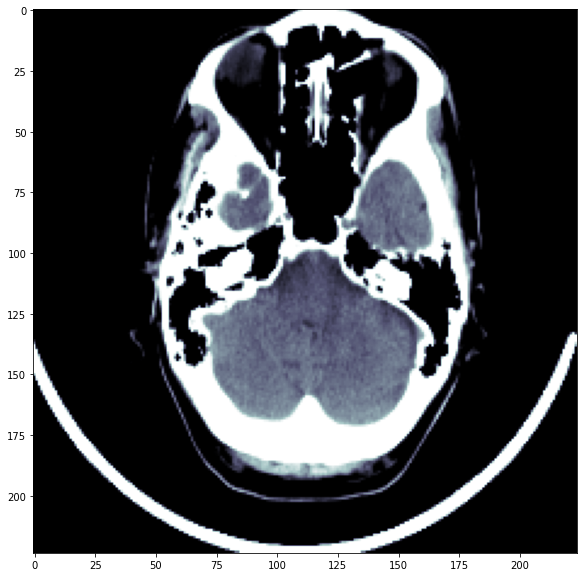

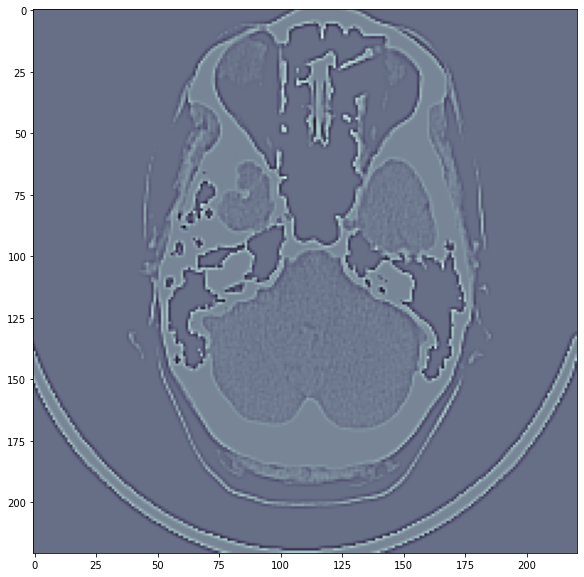

In [4]:
def problem_1(file_name):
    #show initial image
    dcm = pydicom.dcmread(file_name)
    image = preprocess(dcm)
    fig=plt.figure(figsize=(15, 10))
    plt.imshow(image, cmap=plt.cm.bone)
    #Build kernel
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    
    #apply convolution
    after = filter_lin(image, kernel)
    #show output
    fig=plt.figure(figsize=(15, 10))
    plt.imshow(after, cmap=plt.cm.bone)
problem_1("ID_0002a616e.dcm")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


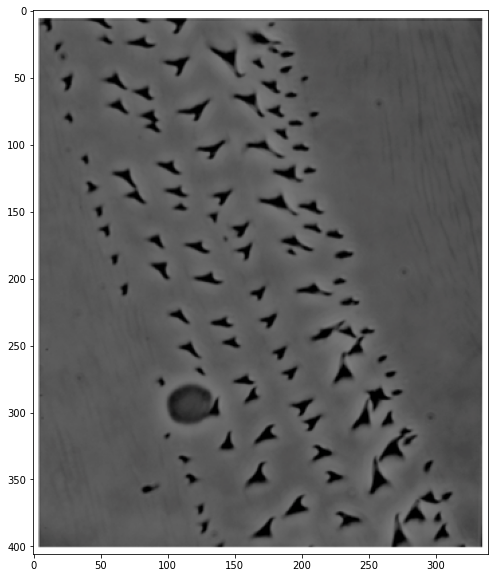

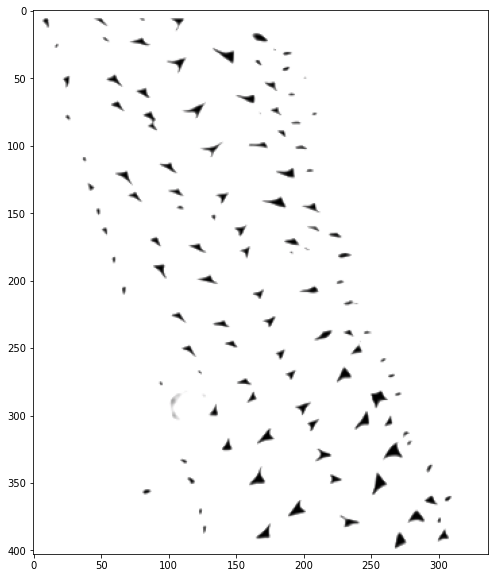

In [5]:
def problem_2(image_path, template_path):
    image = plt.imread(image_path)
    template = plt.imread(template_path)
    template = cv2.resize(template, (3, 3))
    fig=plt.figure(figsize=(15, 10))
    plt.imshow(image)
    (x, y) = image.shape[0], image.shape[1]
    out = []
    for i in range(x-3):
        row = []
        for j in range(y-3):
            row.append(mult(image, template, i, j))
        out.append(row)
    out = np.array(out)
    fig=plt.figure(figsize=(15, 10))
    plt.imshow(out)

problem_2("Screen Shot 2021-01-27 at 4.18.36 PM.png", "Screen Shot 2021-01-27 at 4.19.06 PM.png")
    

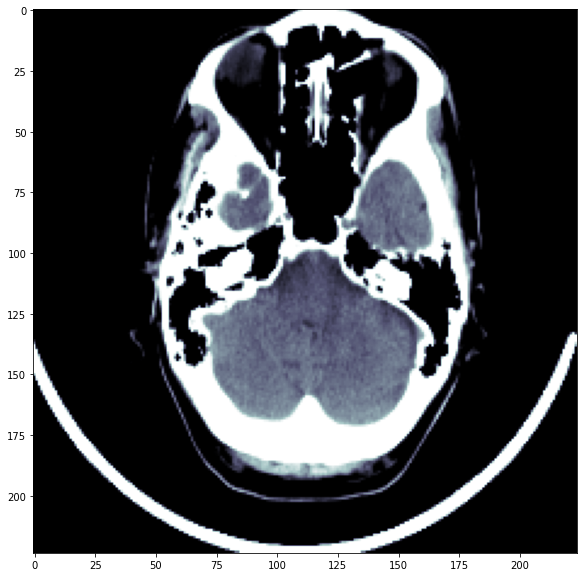

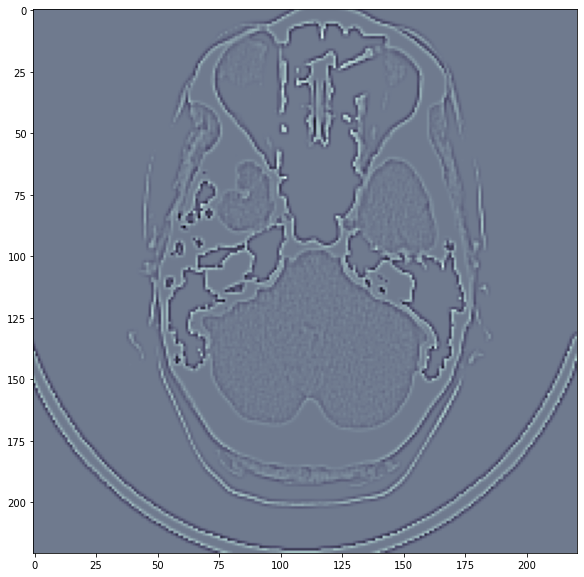

In [6]:
def problem_3(file_name):
    #show initial image
    dcm = pydicom.dcmread(file_name)
    image = preprocess(dcm)
    fig=plt.figure(figsize=(15, 10))
    plt.imshow(image, cmap=plt.cm.bone)
    #Build kernel
    kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    #apply convolution
    after = filter_lin(image, kernel)
    #show output
    fig=plt.figure(figsize=(15, 10))
    plt.imshow(after, cmap=plt.cm.bone)

problem_3("ID_0002a616e.dcm")

In [6]:
def main():
    problem_1("ID_0002a616e.dcm")
    problem_2("Screen Shot 2021-01-27 at 4.18.36 PM.png", "Screen Shot 2021-01-27 at 4.19.06 PM.png")
    problem_3("ID_0002a616e.dcm")